# Multiparameter persistence introduction

In [27]:
import multipers as mp
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd
import multipers.plots as mpp
np.random.seed(1)

**Remark.** As we mainly focus on Multiparameter Topological Persistence here, the usual 1-parameter Persistence setting is not well detailed here. 
<br>
We recommend the reader to familiarize first with persistent homology to have a better understanding of this notebook. 

## Point clouds

### Topological Persistence and Noise
#### Standard approach

Let's start with a standard annulus. 

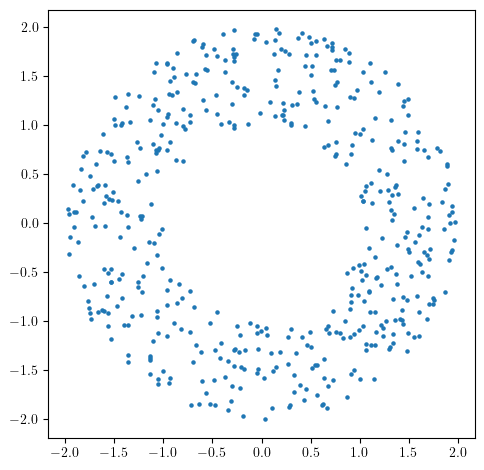

In [28]:
from multipers.data.synthetic import noisy_annulus
X = noisy_annulus(n1=500, n2=0)
plt.scatter(X[:,0], X[:,1], s=5); plt.gca().set_aspect(1)

As this is very close to the annulus (w.r.t., e.g., the Haussdorff distance), its persistence will be close to the one of the annulus, i.e.,
 - In degree 0, one connected component appearing at time 0, and never dying,
 - In degree 1, one cycle appearing at time 0, and dying at the diameter of the inner radius of the annulus (1).

More formally, we're looking at the persistence of topological signal (here homology) along the familly of topological spaces (topological filtration)

$$X = (X_t)_{t\ge 0} \quad \text{where } X_t := \{ x \in \mathbb R ^2 : d(x, X) \le t\} = \bigcup_{x\in X} B(x,t)$$

Now as the topology of $X_t$ change over time ($t$), one can track the appearance of topological signal and its persistence over time.
<br>
This is exactly what we recover using Persistent Homology, which gives us, for each such topological signal, its lifetime w.r.t. the time $t$, in a *so-called* barcode: the familly of bars representing these lifetimes.
<br>
**Note.** These bars can be represented in a *Persistence Diagram* by coordinates in $\mathbb R^2$ in the coordinate system $(\text{birth}, \text{death})\in \mathbb R^2$.

<Axes: title={'center': 'Persistence barcode'}>

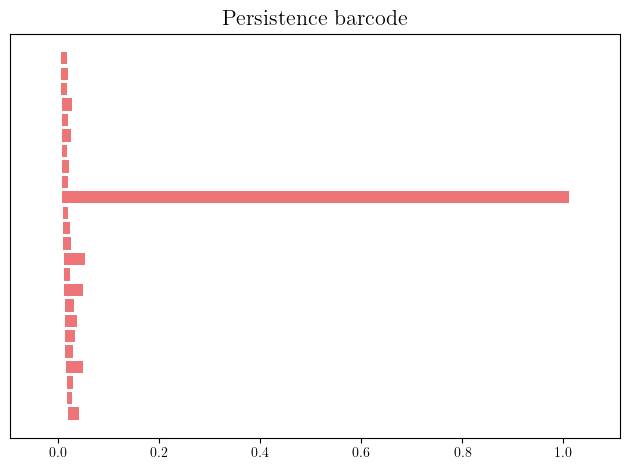

In [29]:
st = gd.AlphaComplex(points=X).create_simplex_tree()
st.compute_persistence(min_persistence=.01)
persistence=st.persistence_intervals_in_dimension(1)
gd.plot_persistence_barcode(persistence=persistence)

Let's add some noise now. 
When more cycles are present, we usually plot points on a *persistence diagram*, 
which represents each `[birth, death]` bar in $\mathbb R^2$ with the point `(birth, death)`.

/home/dloiseau/micromamba/envs/313/lib/python3.13/site-packages/gudhi/persistence_graphical_tools.py:107: UserWarning: There are 955 intervals given as input, whereas max_intervals is set to 50.
  warnings.warn(


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

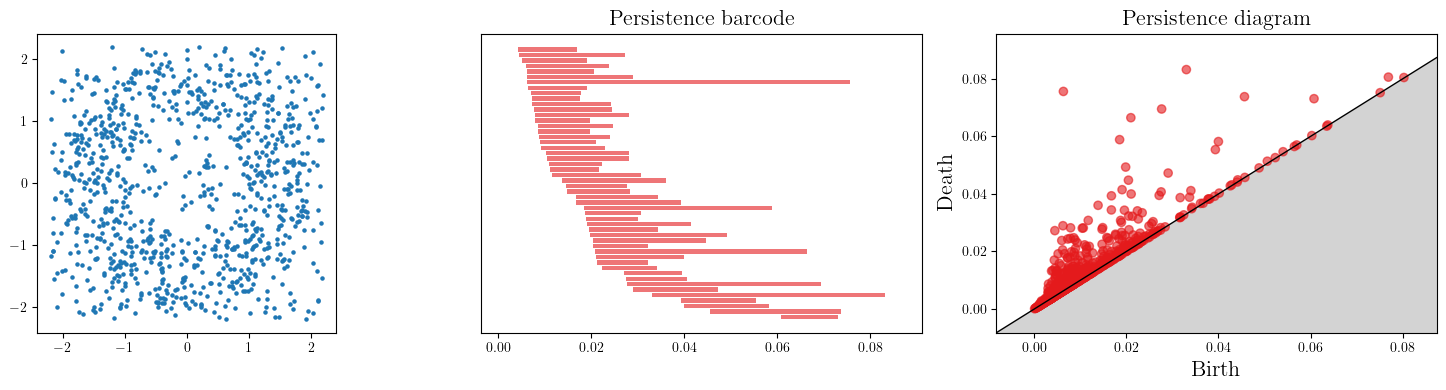

In [30]:
X = noisy_annulus(n1=500, n2=500)
fig, (a,b,c) = plt.subplots(ncols=3, figsize=(15,4))
plt.sca(a)
plt.scatter(X[:,0], X[:,1], s=5); plt.gca().set_aspect(1)
st = gd.AlphaComplex(points=X).create_simplex_tree()
st.compute_persistence()
persistence=st.persistence_intervals_in_dimension(1)
gd.plot_persistence_barcode(persistence=persistence, axes=b, max_intervals=50)
gd.plot_persistence_diagram(persistence=persistence, axes=c)

As one can see, the persistence completely changed! and we cannot recover the original annulus, as the few points in the middle filled the gap in the middle.

One way to deal with this issue is to take into account the sampling measure of the dataset; it is much more concentrated on the annulus than on the diffuse noise.

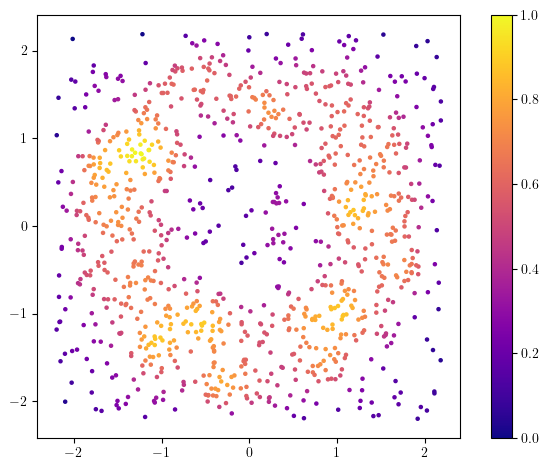

In [31]:
from multipers.filtrations.density import KDE
density = KDE(bandwidth=0.2).fit(X).score_samples(X)
# a bit of renormalization
density -= density.min()
density /= density.max()

plt.scatter(X[:,0], X[:,1], s=5, c=density, cmap="plasma")
plt.gca().set_aspect(1); plt.colorbar();

And now, a first idea would be to remove the low density points, which should correspond to some noise

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

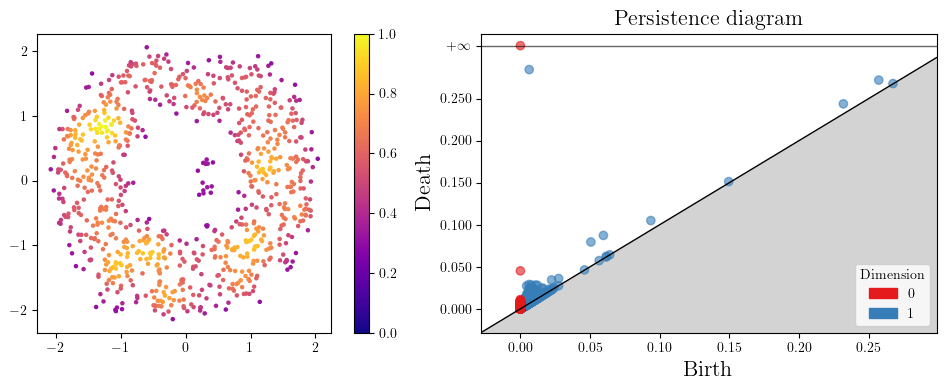

In [32]:
threshold = .3
idx = density>threshold
fig, (a,b) = plt.subplots(ncols=2, figsize=(10,4))
plt.sca(a)
plt.scatter(X[idx,0], X[idx,1], s=5, c=(density[idx]), cmap="plasma", vmin=0); plt.gca().set_aspect(1), plt.colorbar()
persistence = gd.AlphaComplex(points=X[idx]).create_simplex_tree().persistence()
gd.plot_persistence_diagram(persistence=persistence, axes=b)

This seems to work! But there are a few caveats, in particular in this (easy) example
 - The choice of threshold is easy here, but in practice, this choice is **not** canonical, and may not even exist,
 - The cycle isn't dying at the proper place (0.3 instead of 1) because of the few points in the middle 

#### Going multiparameter
A better strategy is to use two parameter persistence.
We were using previously the topological filtration

$$X = (X_t)_{t\ge 0} \quad \text{where } X_t := \{ x \in \mathbb R ^2 : d(x, X) \le t\} = \bigcup_{x\in X} B(x,t)$$

And we'll add a second axis, which will be defined by the codensity of the point cloud. This defines a 2-parameter filtration, on which we'll also track the topological persistence.

$$X = (X_{(t,s)})_{t\ge 0,s\in \mathbb R} \quad \text{where } X_{(t,s)} := \{ x \in \mathbb R ^2 : d(x, X) \le t, \mathrm{density}(x) \ge s \} = \bigcup_{x\in X} B(x,t) \bigcap \mathrm{density}^{-1}(s,\infty)$$

It turns out that this filtration is *not* computable in general, as the density function can be arbitrarily not smooth. 
The filtration we hence consider in this context is an approximation of it: 

$$X = (X_{(t,s)})_{t\ge 0,s\in \mathbb R} \quad \text{where } X_{(t,s)} = \bigcup_{x\in X,\; \mathrm{density}(x)\ge s} B(x,r),$$

that is equivalent (nerve theorem) to the *Delaunay-Codensity* simplicial bifiltration.

To keep it simple, and avoid adding dependencies in this code,
we will consider a simplified one, the *Rips-Codensity* bifiltration, 
which approximates the previous one. 

Please take a look at their corresponding notebooks in the `Filtrations` section for more details.


In [33]:
# as we already computed the density, we just need the RipsLowerstar filtration
from multipers.filtrations import RipsLowerstar, RipsCodensity
simplextree = RipsLowerstar(points=X, function = 1-density, threshold_radius=2.5) # this is a simplicial complex
simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)

SimplexTreeMulti[dtype=float64,num_param=2,kcritical=False,is_squeezed=False,max_dim=2]

## Multipersistence representations

### Multiparameter Module Approximation (MMA)

**Note:** In this subsection, we focus on "multipers-only" functions; a bunch of steps can be **significantly** speed up using external libraries, as showcased in next sections.

A representation of the 2 persistence can be computed using interval decomposition technics, such as our `multiparameter_module_approximation` module.
Theoretical definitions can be found in the [MMA paper](https://arxiv.org/abs/2206.02026).
<br>
Here each interval, i.e., colored shape, visually correspond to the lifetime of a cycle in this 2-filtration.
<br>
You can morally interpret this as a barcode for each density horizontal stratum that are *properly glued* vertically together.
<br>
As you can see, there is one significant shape that stands out, which correspond to the annulus.

Text(0, 0.5, 'Codensity axis')

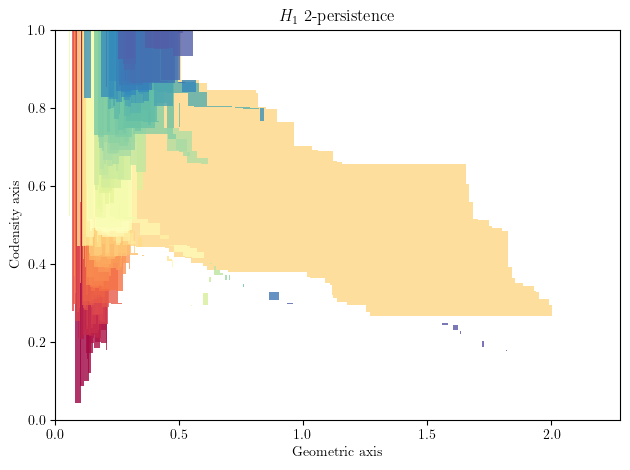

In [34]:
bimod = mp.module_approximation(simplextree)
bimod.plot(degree=1)
plt.xlabel('Geometric axis')
plt.ylabel('Codensity axis')

Surprisingly, these approximations can be used to compute very efficiently [Multiparameter Persistent Landscapes](https://jmlr.org/papers/v21/19-054.html), or any vectorization from [A Framework for MPH Decompositions Representations](https://proceedings.neurips.cc/paper_files/paper/2023/hash/702b67152ec4435795f681865b67999c-Abstract-Conference.html). This makes [MMA modules](https://arxiv.org/abs/2206.02026) a very good structure to compute for hyperparameter cross validation! 

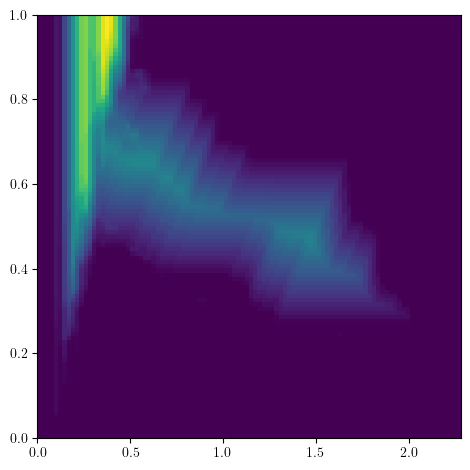

In [35]:
bimod.landscapes(degree=1, ks=range(5), plot=True); # Landscape of degree one with k=0,1,2,3,4

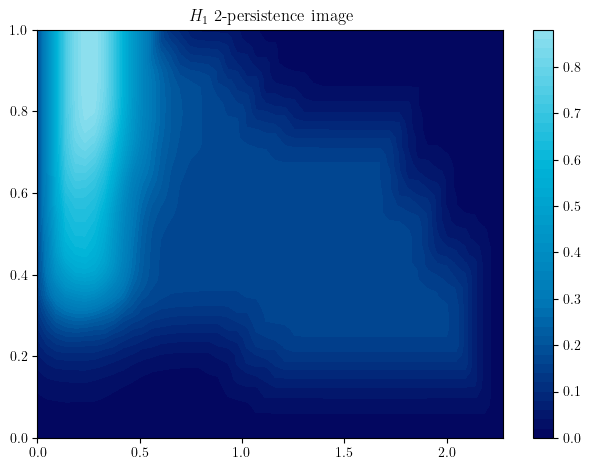

In [36]:
bimod.representation(
    degrees=[1], # homological degrees to compute
    bandwidth=.1, #bandwidth parameter of the representation 
    plot=True, 
    p=2, # L^2 weight on summands
    kernel="gaussian", # exponential,linear or custom kernels are possible
    signed=False, # Signed representations
); # An image representation of the bimod

The `multipers.ml.mma` module, containing (among other) `MMAFormatter`, `MMA2Img`, `MMA2Landscape` can also help you to achieve this in a more scalable way

### Signed Barcode Decompositions as Signed Measures

Although this structure is more visually intepretable, it can still be too expensive to compute depending on the usecase. 
<br> 
An alternative option, is to compute [Signed Barcode](https://arxiv.org/abs/2107.06800), which provide a bunch of weaker topological invariants, that can be used in a ML context
as [Signed Measures](https://proceedings.neurips.cc/paper_files/paper/2023/hash/d75c474bc01735929a1fab5d0de3b189-Abstract-Conference.html). 
<br> 
This library has several of them : 
 - **Hilbert function decomposition**,
 - **Rank decomposition** (via rectangles or hooks), 
 - **Euler Characteristic decomposition**.


The easiest to understand might be the `hilbert signed measure`, which is derived from the dimension vector of this previous 2-parameter module.
<br>
In the figure below, on the left you have the pointwise dimension of the bimodule (a.k.a. The Hilbert Function), and on the right its associated signed measure,
that can be interpreted as the "changes" of values of the hilbert function on the left.

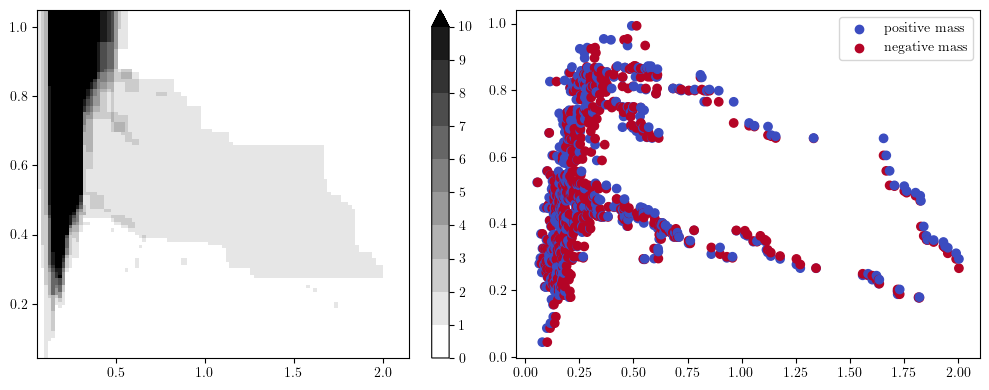

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
hilbert_sm = mp.signed_measure(simplextree, degree=1) # computes the hilbert decomposition signed measure 
surface, grid =  mp.point_measure.integrate_measure(*hilbert_sm[0], return_grid=True) # integrates the measure on a grid (left plot)
mpp.plot_surface(grid, surface, discrete_surface=True, ax=ax1)
mpp.plot_signed_measure(*hilbert_sm, ax=ax2)

You can interpret the measure on the right as follows
 - each blue dot correspond to "something that appear in homology at this grade"
 - each red dot correspond to "something that dies in homology at this grade"

We refer the reader to the [Signed Measures](https://proceedings.neurips.cc/paper_files/paper/2023/hash/d75c474bc01735929a1fab5d0de3b189-Abstract-Conference.html) paper for formal definitions.

Signed measures can also be computed from different topological invariant derived from a $n$-parameter persistence module, e.g., the *Euler characteristic*, which leads to the *Euler signed masure*. This one can be very fast to compute, but is not well suited to be used on point clouds, as it has to be computed on the full simplicial complex, i.e., using the simplices of all dimension, which can be prohibitive to store.
<br>
In this example, we compute this invariant on a `regular` smaller subgrid to be able to hold this invariant in memory.

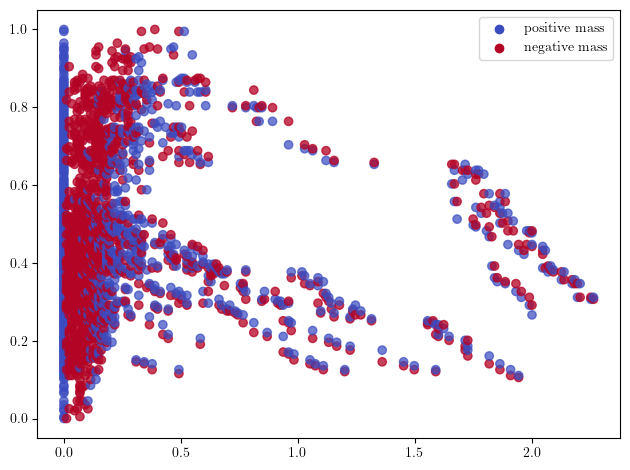

In [45]:
coarsenned_st = (
    simplextree
    .grid_squeeze(strategy="regular", resolution=200) # coarsenning
    .collapse_edges(-2) # it can now be simplified again
)
coarsenned_st.expansion(coarsenned_st.num_vertices) # Euler characteristic requires every simplices of every dimension to be computed
euler_sm = mp.signed_measure(
    coarsenned_st, 
    degree=None, plot=True
); # Actual computation, degree=None is the Euler characteristic 

Or the rank invariant decompositions, which is in general harder to compute than MMA modules, but can be restricted to smaller subgrids to have reasonable compute times.

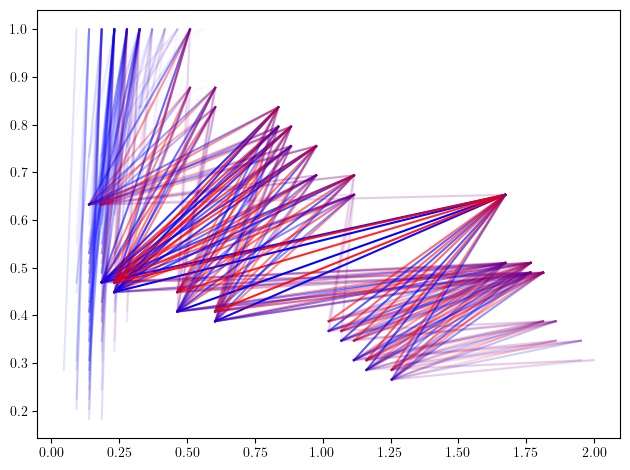

In [55]:
simplextree.prune_above_dimension(2) ## The simplices above dimension 2 are not necessary here; this speeds up the computations.
grid = mp.grids.compute_grid( ## Computes a subgrid
    simplextree,
    strategy="regular", # i.e., will return a regular grid
    resolution=50,
) 
rank_sm = mp.signed_measure(
    simplextree.grid_squeeze(grid), # we coarsen the simplextree before feeding it to the invariant computation
    degree=1, 
    invariant = "rank", # The default one is using rectangle decompositions.
    plot = True, 
);

In this plot, each blue line $[b,d]\in B$ correspond to a positive dirac $\delta_{(b,d)}$ on the point $(b,d)\in \mathbb R^2$, while red lines $[b,d]\in D$ correspond to $-\delta_{(b,d)}$.
<br>
This defines a signed measure 
$$\mu^{\mathrm{rk}}_M:= \sum_{[b,d]\in B}\delta_{(b,d)} - \sum_{(b,d)\in D}\delta_{(b,d)}$$
satisfying 
$$\forall x,y\in \mathbb R^2,\quad \mathrm{rk}[M(x\le y)] = \iint_{a\le x\le y \le b} \mathrm{d}\mu^{\mathrm{rk}}_M(a,b).$$

Equivalently, this can be viewed as the following rank decomposition (this is the minimal signed barcode):
$$\forall x,y\in \mathbb R^2,\quad \mathrm{rk}[M(x\le y)] =  \mathrm{rk}\left[\bigoplus_{(b,d)\in B}k^{[b,d)}(x\le y)\right] - \mathrm{rk}\left[\bigoplus_{(b,d)\in D}k^{[b,d)}(x\le y)\right],$$

where $k^{[b,d)}$ are the rectangle interval modules, with the rectangle support $\{x\in \mathbb R^2\mid b\le x < d\}$, whose minimal presentation is given by:

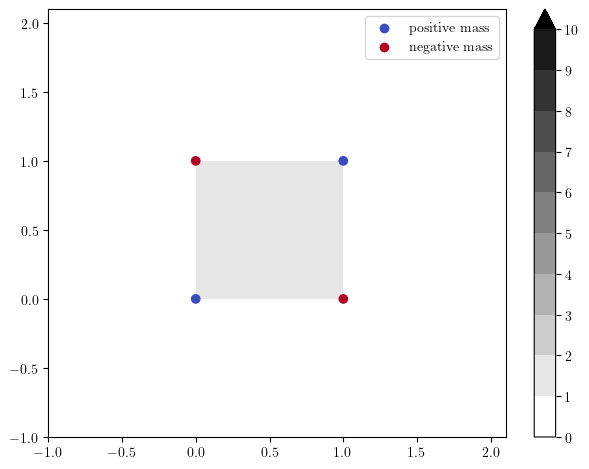

In [60]:
x = [0.,0.]
y = [1.,0]
z = [0.,1]
pres_matrix = [[],[0],[0]]
grades = [x,y,z]
dimensions = [0,1,1] # 0 for generators, 1 for relations

# The rectangle module 
s = mp.Slicer(return_type_only=True)(pres_matrix,dimensions,grades)

# Plots
simple_grid=np.array([[-1,0,1,], [-1,0,1.]]) # for the plot
hook_module_sm, = mp.signed_measure(s, degree=0, invariant="hilbert") 
hilbert_f = mp.point_measure.integrate_measure(*hook_module_sm, filtration_grid = simple_grid, plot=True)
mp.plots.plot_signed_measure(hook_module_sm)

The minimal rank decomposition via hook modules can be obtained with the following: 

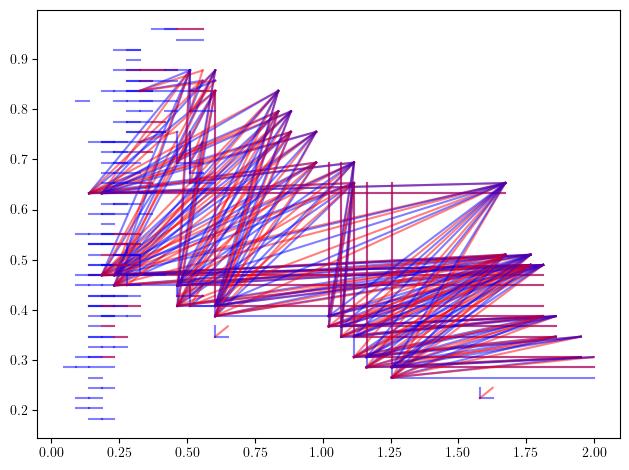

In [57]:
hook_sm, = mp.signed_measure(
    simplextree.grid_squeeze(grid),
    degree=1,
    invariant = "hook", # The default one is using rectangle decompositions.
);
mp.plots.plot_signed_measure(hook_sm, alpha=.5)

The hook decomposition signed measure has a similar interpretation, when replacing rectangles with hook modules,
which are interval modules $k^{\left<x,y\right<}$ with support 
$$\left<x,y\right< := \{z\in \mathbb R^2\mid x\le z\textnormal{ and } z\not\ge y\}.$$

Their presentation is given by a generator at grade $x$ and a relation, killing this only generator at grade $y$.

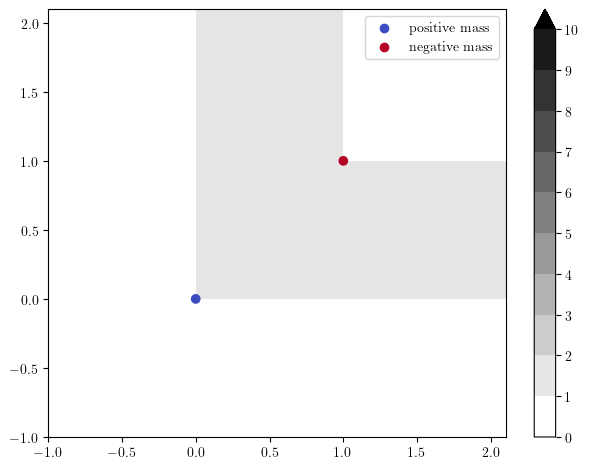

In [61]:
x = [0.,0.]
y = [1.,1.]
pres_matrix = [[],[0]]
grades = [x,y]
dimensions = [0,1] # 0 for generators, 1 for relations

# The hook module
s = mp.Slicer(return_type_only=True)(pres_matrix,dimensions,grades)

# Plots
simple_grid=np.array([[-1,0,1,], [-1,0,1.]])
hook_module_sm, = mp.signed_measure(s, degree=0, invariant="hilbert") 
hilbert_f = mp.point_measure.integrate_measure(*hook_module_sm, filtration_grid = simple_grid, plot=True)
mp.plots.plot_signed_measure(hook_module_sm)

The resulting measure, $\mu^{\mathrm{hook}}_M$, satisfies 
$$\forall x,y\in \mathbb R^2,\quad \mathrm{rk}[M(x\le y)] = \iint_{a\le x\le \textnormal{ and } b\not\ge y} \mathrm{d}\mu^{\mathrm{hook}}_M(a,b).$$
Furthermore, we equivalently have the (minimal) signed barcode:
$$\forall x,y\in \mathbb R^2,\quad \mathrm{rk}[M(x\le y)] =  \mathrm{rk}\left[\bigoplus_{(b,d)\in B}k^{\left<b,d\right<}(x\le y)\right] - \mathrm{rk}\left[\bigoplus_{(b,d)\in D}k^{\left<b,d\right<}(x\le y)\right],$$


These measures can also easily be turned into vectors using the `SignedMeasure2Convolution` method

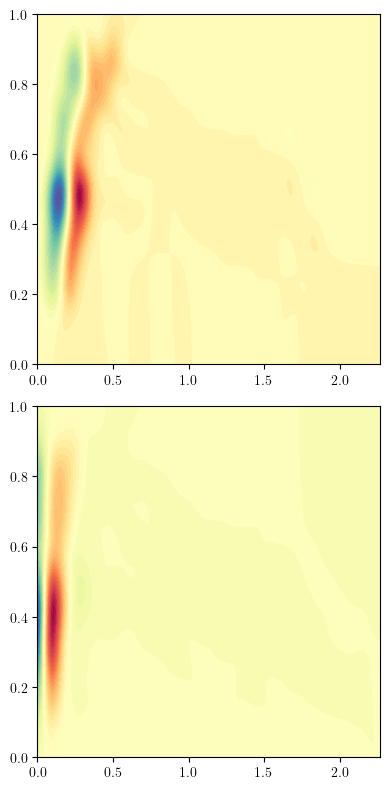

In [67]:
from multipers.ml.signed_measures import SignedMeasure2Convolution
# [hilbert_sm, euler_sm] = mms.SignedMeasureFormatter(normalize=True).fit_transform([hilbert_sm, euler_sm]) ## for better plots, we normalize the filtrations
SignedMeasure2Convolution(plot=True, bandwidth=.05, grid_strategy="regular", resolution=200).fit_transform([hilbert_sm, euler_sm]);

## Another approach, with external libraries

We consider the same strategy as above but with another dataset. We will see that we are able to use the concentration of the sampling measure to our adventage.
<br>
Rips can become quite large on bigger datasets, so we will consider [Function Delaunay](https://arxiv.org/abs/2310.15902) bifiltrations instead, on which we compute minimal presentation to compute our invariants, with [mpfree](https://doi.org/10.1137/1.9781611976472.16).

You will need these two dependencies to execute the following code. [FunctionDelaunay](https://bitbucket.org/mkerber/function_delaunay) and [mpfree](https://bitbucket.org/mkerber/mpfree).

Text(0.5, 1.0, 'Three annulus dataset (size 50000)')

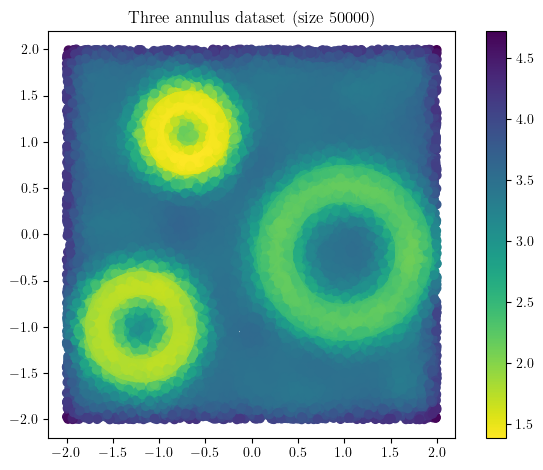

In [69]:
from multipers.data.synthetic import three_annulus
X = three_annulus(25_000,25_000)
density = KDE(bandwidth=0.15, return_log=True).fit(X).score_samples(X)
plt.scatter(*X.T, c = -density, cmap="viridis_r")
plt.gca().set_aspect(1); plt.colorbar()
plt.title(f"Three annulus dataset (size {X.shape[0]})")

We first compute the Density-Delaunay bifiltration, mentioned at the begining using

In [70]:
from multipers.filtrations import DelaunayLowerstar
function_delaunay = DelaunayLowerstar(points = X, function = -density) ## needs function_delaunay

On which we compute the minimal presentation of degree 1, using mpfree.

In [71]:
minimal_presentation = function_delaunay.minpres(degree=1).to_colexical() ## needs mpfree
# Note. These two steps can be done faster by providing the degree to function_delaunay

There are different options there, but in this case we end up with a `Slicer` structure, which can be used to compute our previous invariant, in a much quicker way. 

As expected, we can clearly distinguish the 3 circles as the 3 big shapes in the figure below, and identify them using their radii. The surprising part is that multiparameter persistence also allows us to identify them using the **concentration** of their sampling ! This allows to retrieve much more information from the dataset :)
<br>
**Exercice:** Can you identify where is the 4th cycle in the original dataset ? 

/tmp/ipykernel_127703/4231174875.py:1: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  mp.module_approximation(minimal_presentation, direction=[1,0], swap_box_coords=[1]).plot(1, alpha=.8)


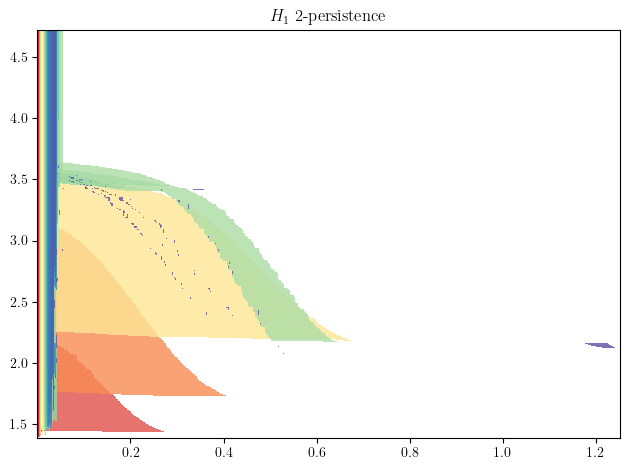

In [72]:
mp.module_approximation(minimal_presentation, direction=[1,0], swap_box_coords=[1]).plot(1, alpha=.8)
# Note. The optional parameters are meant to speed up computations in this specific context, and can be removed. Plot also takes a lot of time here

The Hilbert Signed measure can be directly retrieved from the minimal resolution, as the euler charteristic of the minimal free resolution is the hilbert function.

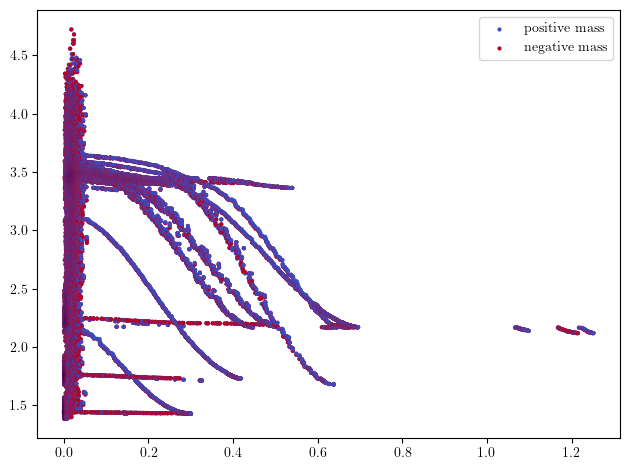

In [73]:
hilbert_sm, = mp.signed_measure(minimal_presentation)
mpp.plot_signed_measure(hilbert_sm, s=4)

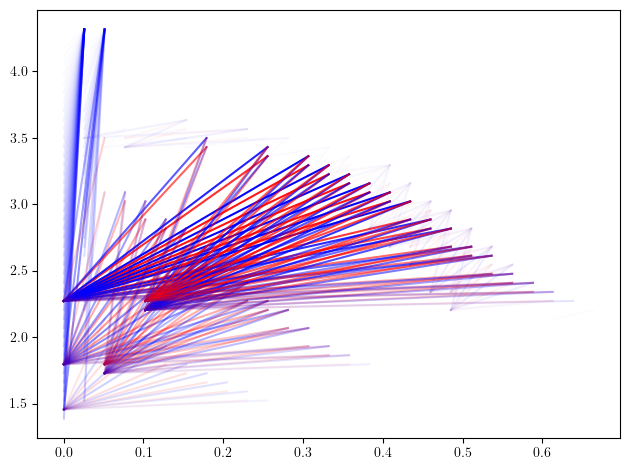

In [74]:
# rank invariant is slow to compute, we coarsenn the grid first using `grid_squeeze`.
coarsenned_presentation = minimal_presentation.grid_squeeze(strategy="regular_closest", resolution=50) 
rank_sm, = mp.signed_measure(coarsenned_presentation, invariant = "rank", degree=1)
mpp.plot_signed_measure(rank_sm)

The euler characteristic can be computed from the original function delaunay (with all the simplices)

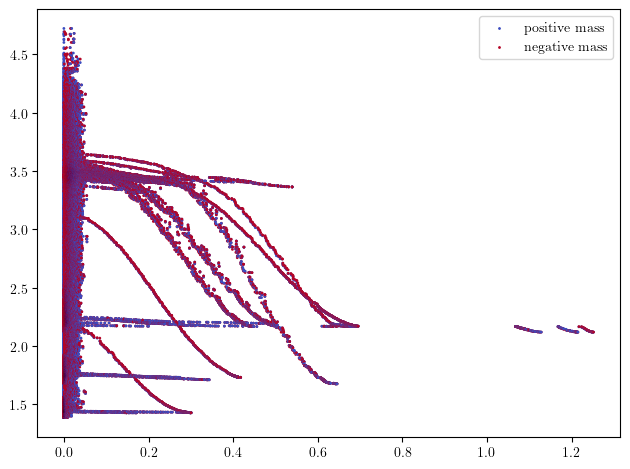

In [75]:
euler_sm, = mp.signed_measure(function_delaunay) 
mpp.plot_signed_measure(euler_sm, s=1)